In [1]:
import pandas as pd
import tqdm
import openai
import nltk
import matplotlib.pyplot as plt
import numpy as np
import os

from pyprojroot import here
from moral_foundations_llms import utils
from textwrap import dedent

%matplotlib inline

In [2]:
api_path = os.path.join(os.environ['HOME'], 'openai/api.txt')

In [3]:
with open(api_path, 'r') as f:
    openai.api_key = f.read().strip()

In [4]:
df = pd.read_csv(here('data/aita_processed_gpt.csv'))

In [18]:
def create_prompt(post):
    return dedent(f"""Please evaluate the following post on from the subreddit "Am I the Asshole":

    {post}

    Which choice below best desribes the original poster (OP) of the above text?
    Respond solely with A, B, C, D, or E.

    A. OP is the asshole: they are at fault in their situation.
    B. OP is not the asshole: they are NOT to blame and the other party described in their scenario is to blame.
    C. Everyone sucks here: both parties are to blame - both people involved in the scenario should be held responsible.
    D. No assholes here: neither party is to blame. All parties actions are justified. Nobody needs to be held accountable. Shit happens.
    E. Not enough info: OP never clarifies details that would determine the true judgment.

    Answer:

    """)

In [23]:
idx = 453
response = openai.Completion.create(
    model='text-davinci-002',
    prompt=create_prompt(df['selftext'].iloc[idx]),
    temperature=0.,
    logit_bias={32: 10, 33: 10, 34: 10, 35: 10, 36: 10},
    logprobs=5
)

In [10]:
log_probs = np.zeros((100, 5))

In [24]:
response['choices']

[<OpenAIObject at 0x7f3731b75800> JSON: {
   "text": "B",
   "index": 0,
   "logprobs": {
     "tokens": [
       "B"
     ],
     "token_logprobs": [
       -0.04716218
     ],
     "top_logprobs": [
       {
         "B": -0.04716218,
         "C": -4.2895517,
         "D": -4.4108305,
         "E": -4.7877207,
         "A": -4.869342
       }
     ],
     "text_offset": [
       2992
     ]
   },
   "finish_reason": "stop"
 }]

In [29]:
ruff[:100, 0]

array([1.68933701e-04, 2.04637960e-04, 4.67520331e-06, 1.33946956e-06,
       1.72382266e-05, 6.94666518e-05, 1.09097481e-05, 9.01137626e-05,
       4.55391356e-04, 9.17234396e-01, 1.51572983e-04, 3.19792092e-06,
       1.74468308e-03, 6.37534318e-05, 2.00111057e-04, 1.91784634e-04,
       2.36547984e-05, 3.11577822e-03, 2.94396051e-06, 5.80797030e-03,
       8.59906633e-06, 5.49479856e-05, 3.61750514e-05, 9.43440033e-06,
       3.94882595e-04, 6.83243960e-05, 1.08906903e-03, 3.36471289e-04,
       5.22679846e-05, 2.44155675e-06, 1.37920549e-04, 2.63769313e-06,
       3.82476910e-03, 4.27229916e-04, 3.06137985e-05, 2.15876124e-05,
       5.17911633e-04, 2.60384961e-01, 2.56537262e-06, 1.71857069e-06,
       1.34319406e-05, 8.61878171e-07, 1.06177190e-03, 2.86004816e-03,
       1.19904617e-03, 2.12074327e-04, 7.60500647e-05, 1.30644794e-03,
       2.44576952e-05, 1.86536490e-05, 8.08816900e-02, 7.30520781e-05,
       1.08022751e-06, 2.45980865e-04, 1.22341063e-04, 8.74767099e-05,
      

(array([98.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.70169827e-07, 9.17236827e-02, 1.83447095e-01, 2.75170508e-01,
        3.66893920e-01, 4.58617333e-01, 5.50340745e-01, 6.42064158e-01,
        7.33787571e-01, 8.25510983e-01, 9.17234396e-01]),
 <BarContainer object of 10 artists>)

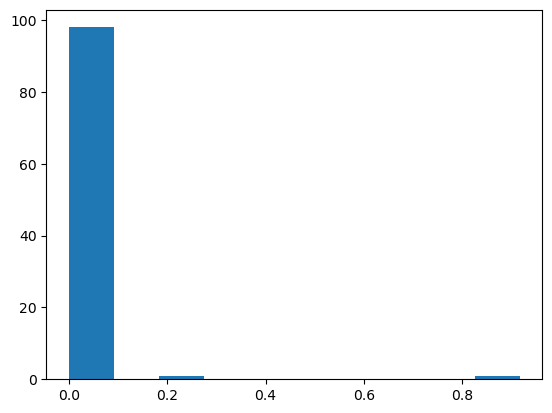

In [28]:
ruff = np.exp(log_probs) / np.sum(np.exp(log_probs), axis=1, keepdims=True)

plt.hist(ruff[:100, 0])

In [30]:
for ii in range(100):
    response = openai.Completion.create(
        model='text-davinci-003',
        prompt=create_prompt(df['selftext'].iloc[ii]),
        temperature=0.,
        logit_bias={32: 5, 33: 5, 34: 5, 35: 5, 36: 5},
        logprobs=5)

    log_prob_json = response['choices'][0]['logprobs']['top_logprobs'][1]
    min_log_prob = min(log_prob_json.values())
    for idx, label in enumerate(['A', 'B', 'C', 'D', 'E']):
        if label in log_prob_json:
            log_probs[ii, idx] = log_prob_json[label]
        else:
            print(f'post {ii}, label {label}')
            log_probs[ii, idx] = min_log_prob


In [31]:
print(response['choices'][0]['text'])
print(df['gpt_label'].iloc[idx])
print(df['true_label'].iloc[idx])


B. OP is not the asshole: they are NOT to blame and the
NTA
NTA


In [10]:
response['choices'][0]['logprobs']['top_logprobs']

[<OpenAIObject at 0x7fbdc0ef9b70> JSON: {
   "\n": -0.07825902,
   "B": -3.1774561,
   "C": -3.543688,
   "A": -6.070783,
   "D": -6.2590785
 },
 <OpenAIObject at 0x7fbdc0ef9c10> JSON: {
   "B": -0.5043088,
   "C": -1.4285183,
   "D": -1.9130802,
   "A": -4.879633,
   "E": -6.735927
 },
 <OpenAIObject at 0x7fbdc0ef9cb0> JSON: {
   ".": -0.122198336,
   "<|endoftext|>": -2.174096,
   ")": -7.4100127,
   ":": -8.830129,
   "D": -9.437999
 },
 <OpenAIObject at 0x7fbdc0ef9d50> JSON: {
   " OP": -0.04143783,
   " The": -3.6394012,
   "<|endoftext|>": -4.638189,
   "OP": -7.0547843,
   " Ex": -7.333433
 },
 <OpenAIObject at 0x7fbdc0ef9df0> JSON: {
   " is": -0.00033319838,
   " did": -9.144443,
   "B": -9.258782,
   " isn": -10.602748,
   "A": -11.165744
 },
 <OpenAIObject at 0x7fbdc0ef9e90> JSON: {
   " not": -0.00047445972,
   " the": -8.043888,
   " NOT": -9.002363,
   "A": -11.6875925,
   " Not": -12.617491
 },
 <OpenAIObject at 0x7fbdc0ef9f30> JSON: {
   " the": -0.00082516216,
   " to"

In [239]:
print(response['choices'][0]['logprobs']['top_logprobs'][1].keys())
logprobs = list(response['choices'][0]['logprobs']['top_logprobs'][1].values())
np.exp(logprobs) / np.sum(np.exp(logprobs))

dict_keys(['B', 'C', 'D', 'A', 'E'])


array([0.5595724 , 0.27098045, 0.15979019, 0.00840306, 0.00125391])